In [3]:
#!/usr/bin/env python
import sys,os
#print sys.path
sys.path=["/home/Zhi/QA-sim","/home/Zhi/april/py"]+sys.path
print(sys.path)
from Parameter import Parameter
from BaseLikelihood import BaseLikelihood
import MCMCAnalyzer
import numpy as np
import quasim as qua
import math
import matplotlib.pyplot as plt
import corner
from uncertainties import ufloat
from uncertainties.umath import sqrt

['/home/Zhi/QA-sim', '/home/Zhi/april/py', '/home/Zhi/QA-sim/notebook', '/usr/lib64/python39.zip', '/usr/lib64/python3.9', '/usr/lib64/python3.9/lib-dynload', '', '/home/Zhi/.local/lib/python3.9/site-packages', '/usr/lib64/python3.9/site-packages', '/usr/lib/python3.9/site-packages', '/usr/lib/python3.9/site-packages/IPython/extensions', '/home/Zhi/.ipython']


In [8]:
# Create Input data
QT = qua.QuaTel(DL=np.pi)
BSC = qua.BSC_process("/home/Zhi/QA-sim/bsc5.dat")

lam = 1*10**(-6)
#NEW YORK COORD but the overall baseline is E-W, with B ~ 190m for RA2 = -1.30004
# Change to B~400M for RA2= -1.300085
pos_t_NY = [[-1.3,0.71,6.4*10**(6)],[-1.300085,0.71,6.4*10**(6)]]   #Baseline vector in [RA,DEC,RADIUS] -1.30004
pos = BSC.BSC_filter(pos_t_NY,3)

T = 2000   
print(pos[0])
num, t, baseline, theo_phase, d_source = QT.get_num_photon(pos[0],pos_t_NY,lam,T,'pos')
num = num[0] 
theo_phase = theo_phase[0]

#create simulated data based on theoretical rates generated above
task4 = qua.sim_data(num*10,t,theo_phase,'pos')   
print('theo_d',d_source[0,0,:])
print(QT.ph)

[[4.71700000e+03 3.24765777e+00 4.55506694e-01 3.08390779e+01]
 [4.70700000e+03 3.23978924e+00 4.51099738e-01 4.33612091e+01]]
theo_d [ 0.0026411  -0.00684019  0.00396187]
-2.1765595179585695


In [2]:
d_source

NameError: name 'd_source' is not defined

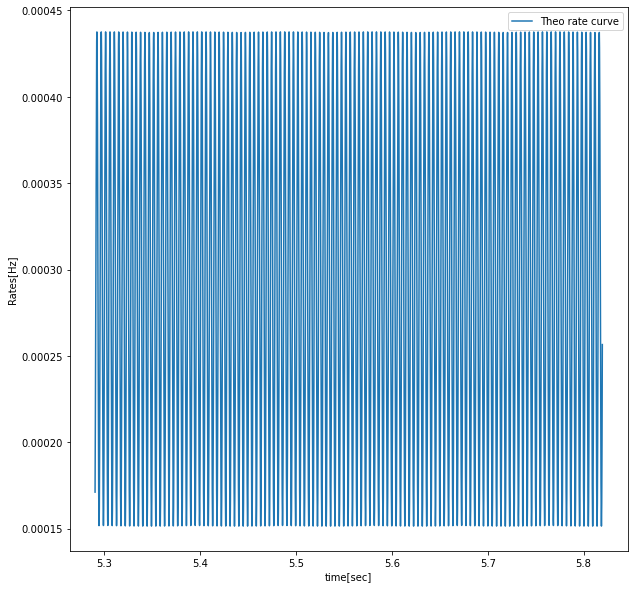

In [14]:
plt.figure(figsize=(10,10))
#plt.xlim([30,30.1])
plt.plot(t[50000:55000],num[50000:55000],label='Theo rate curve')
plt.xlabel('time[sec]');plt.ylabel('Rates[Hz]')
plt.legend()

In [11]:
# Finds theoretical separation and separation by direct subtraction
pos = BSC.BSC_filter(pos_t_NY,3)

def theo_ds(pos, theo):  #pos in [#,phi,dec,s] find midpoint theta and phi.
    
    pos[:,2] = np.pi/2. - pos[:,2]
    print('theo_pos',pos)
    x = np.sin(pos[:,2])*np.cos(pos[:,1])
    y = np.sin(pos[:,2])*np.sin(pos[:,1])
    z = np.cos(pos[:,2])
    #print(x,y,z)
    r = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1],z[0]+z[1]])/2)
    s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    phi = math.atan2((x[0]+x[1]),(y[0]+y[1]))
    

    d_ra = (pos[0,1]-pos[1,1])     
    d_dec = (pos[0,2] - pos[1,2])  
    # Use theo d_source in cart to convert to d_ns and d_ew
    d_dec_theo = -theo[2]*r/s     #
    
    new_x = (((z[0]+z[1])/2)/r)*d_dec_theo
    
    d_ew_x = (theo[0]+np.cos(np.pi/2 + phi)*new_x)/(np.sin(-(np.pi/2 + phi)))
    
    d_ew_y = (-theo[1]-np.sin(-(np.pi/2 + phi))*new_x)/(np.cos(np.pi/2 + phi))
    
    d_ra_theo = d_ew_x*r/s    
    
    print(d_dec)
    print(d_dec_theo)
    
    return d_dec_theo, d_ew_x
    
    #return d_dec, d_ra, d_dec_theo, d_ra_theo


d_ns_theo, d_ew_theo = theo_ds(pos[0],d_source[0,0,:])

#theoretical par value which can be used as initial guess if needed.
theo_par = [task4.V,d_ew_theo,d_ns_theo,QT.ph]
theo_par = [0.48575982471026546, 0.007073847462221948, -0.004406956361285741, -2.1765595179585695]
print('theo_par',theo_par)


theo_pos [[4.71700000e+03 3.24765777e+00 1.11528963e+00 3.08390779e+01]
 [4.70700000e+03 3.23978924e+00 1.11969659e+00 4.33612091e+01]]
-0.00440695636128563
-0.004406959336378575
theo_par [0.48575982471026546, 0.007073847462221948, -0.004406956361285741, -2.1765595179585695]


In [16]:
# create sim_data class for mcmc

class sim_data(BaseLikelihood):
    
    def __init__(self, seed, pos_t, pos_s, t, lam):  # seed = [V_init,d_ra_init, d_dec_init]
        BaseLikelihood.__init__(self,"sim_data")  
        
        # free par
        self.seed = seed
        self.V = seed[0]
        self.d_ew = seed[1]
        self.d_ns = seed[2]
        self.offset = seed[3]
        
        # fixed values
        self.t = t             # timestamp for the sim data
        
        pos_t = np.array(pos_t)
        pos_t[:,1] = np.pi/2 - pos_t[:,1]   # baseline vector in spherical baseline [[phi,theta,r],[phi,theta,r]]
        self.pos_t = pos_t     # position of the two telescope in Earth coordinate
        
        pos_s = np.delete(pos_s, 0, axis=1)  # delete star # part.
        pos_s[:,1] = np.pi/2 - pos_s[:,1]
        self.pos_s = pos_s     # position of sources to determine midpoint
        
        self.lam = lam         # lambda for observation
        self.Omega_E = 7.292e-5
        
    def freeParameters(self):
        return [
                Parameter("V", self.seed[0], err=0.05),    #0.05
                Parameter("d_ew",self.seed[1], err=1e-9),   #1e-7
                Parameter("d_ns",self.seed[2], err=1e-9),
                Parameter("offset",self.seed[3], err=np.pi/5)   #pi/10
                ]
    
    def updateParams(self,params):    #params is also a class, updates param value.
        for p in params:
            if p.name=="V":
                self.V=p.value
            if p.name=="d_ew":
                self.d_ew=p.value
            if p.name=="d_ns":
                self.d_ns=p.value
            if p.name=="offset":
                self.offset=p.value
                
    def pos_carte(self, ti):
            # rotate baseline vector as func of time
            
            if (ti == 0.0).all() :   # for pos source
                x = np.sin(self.pos_s[:,1])*np.cos(self.pos_s[:,0])
                y = np.sin(self.pos_s[:,1])*np.sin(self.pos_s[:,0])
                z = np.cos(self.pos_s[:,1])
               
                r = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1],z[0]+z[1]])/2)
                s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    
                # close to theoretical d_ns and d_ew
                #d_ew = s/r * self.d_ra
                #d_ns = self.d_dec
                
                
                #converting to Earth coord
                #rotate around d_ew axis, y axis
                fin_z = -(s/r)*self.d_ns
                new_x = -(((z[0]+z[1])/2)/r)*self.d_ns    #multiplied by d_ew and d_ns
                
                # rotate around z axis
                phi = math.atan2(((x[0]+x[1]),(y[0]+y[1])))
                
                #fin_x = np.cos(np.pi/2 + phi)*new_x - np.sin(-(np.pi/2 + phi))*self.d_ew
                #fin_y = np.sin(-(np.pi/2 + phi))*new_x + np.cos(np.pi/2 + phi)*self.d_ew
                
                fin_x = np.cos(phi)*new_x - np.sin(phi)*self.d_ew
                fin_y = np.sin(phi)*new_x + np.cos(phi)*self.d_ew
                
                new_pos = np.array([fin_x,fin_y,fin_z])    # since theta hat points down
                print(new_pos)
                return new_pos
            
            else:
                N = ti.size 
                M = len(pos)
                
                new_t = np.tile(ti,(2,1))   # (2,N)
            
                pos_tile = np.tile(np.reshape(self.pos_t,(2,1,3)),(1,N,1))    #pos of telescope, 2,N,3
                
                new_pos = np.zeros((2,N,3))
            
                #change from spherical to cartesian
                new_pos[:,:,0] = pos_tile[:,:,2]*np.sin(pos_tile[:,:,1])*np.cos(pos_tile[:,:,0] + self.Omega_E*new_t)   #[x,y,z](t)
                new_pos[:,:,1] = pos_tile[:,:,2]*np.sin(pos_tile[:,:,1])*np.sin(pos_tile[:,:,0] + self.Omega_E*new_t)
                new_pos[:,:,2] = pos_tile[:,:,2]*np.cos(pos_tile[:,:,1])     

                return new_pos
    
    
    def get_phase(self):       #pos:[[[ra,dec,r],[ra,dec,r]],[[],[]]]

        #let ds be differene of source unit vector
        ds_car = self.pos_carte(np.array([0.]))                   #(3)
        new_pos_t = self.pos_carte(self.t)           #(2,N,3)
        baseline = new_pos_t[1] - new_pos_t[0]      #(3,N)
        #print(baseline)
        dot = baseline[:,0]*ds_car[0] + baseline[:,1]*ds_car[1] + baseline[:,2]*ds_car[2]
        phase = 2*np.pi/self.lam*dot + self.offset   # Total phase with the offset
        
        return phase
    
    
    
    def loglike_wprior(self):
        
        phase = self.get_phase()
        loglike = np.log(1+self.V*np.cos(phase))  #get loglike for diff phase in 2d array[[],[],[]...]
        res = np.sum(loglike, axis=None)
        
        return res
    
    
    


In [17]:
# CREATE CLASS WITH INPUTS

pos = BSC.BSC_filter(pos_t_NY,3)
#pos = np.array([[0,1.2,0.2,450.0],[0,1.202,0.21,90.0]])
# generate some seed
#par = [0.25, d_ra_theo-0.5e-9, d_dec_theo-0.3e-9, -2.0]

#print(pos[16])
#can also use theoretical par value by changing  par to theo_par
L=sim_data(theo_par,pos_t_NY,pos[0],task4.timestamp,lam)  
L.loglike_wprior()

#theo_d [ 0.0026411  -0.00684019  0.00396187]

TypeError: atan2 expected 2 arguments, got 1

[0.00723371 0.00119876 0.00396187]


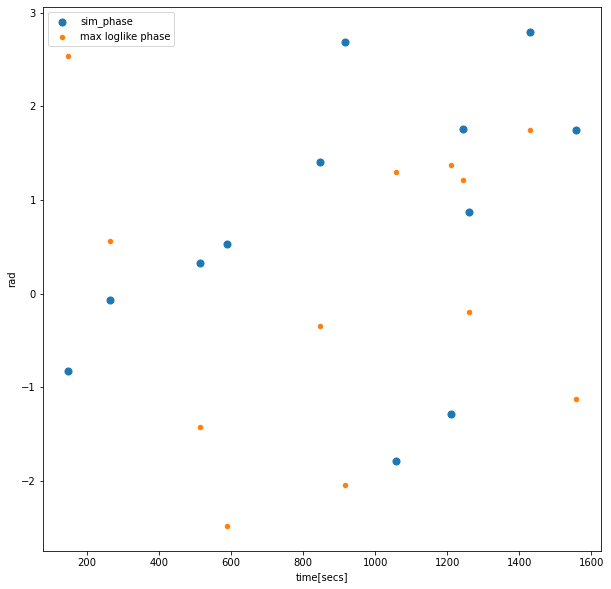

In [85]:
plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)
#plt.plot(t[:200000], np.mod((theo_phase[:200000]+ np.pi),2*np.pi) - np.pi, color = 'g',label='theo phase curve')
plt.scatter(task4.timestamp[-300000:],np.mod((task4.phase[-300000:]+ np.pi),2*np.pi) - np.pi,s=50, label = 'sim_phase')
plt.scatter(task4.timestamp[-300000:], np.mod((L.get_phase()[-300000:]+ np.pi),2*np.pi) - np.pi, s= 20,label = 'max loglike phase')
plt.xlabel('time[secs]');plt.ylabel('rad')
#plt.xlim([14.25,15])
plt.legend()

In [22]:
MCMCAnalyzer.MCMCAnalyzer(L,"/home/Zhi/QA-sim/MCMC_output/sim_data_400m_10x",temp=2, nsamp=300000)

Bounds: [ 2.90452774e-02  5.67231844e-03 -1.09568682e-03 -5.31815217e+00] [ 0.52904528  0.00567233 -0.00109568  0.96503314]
Starting chain...
Accepted samples 1000 1
Accepted samples 2000 1
Accepted samples 3000 1
Accepted samples 4000 1
Accepted samples 5000 2
Re-initializing covariance matrix after burn-in
[[ 1.14002498e-03 -1.25820903e-12 -1.89233086e-12  4.03404799e-03]
 [-1.25820903e-12  3.52365706e-19  1.27054942e-19 -3.32604106e-10]
 [-1.89233086e-12  1.27054942e-19  1.39972195e-19 -3.16697202e-10]
 [ 4.03404799e-03 -3.32604106e-10 -3.16697202e-10  7.55974221e-01]]
V 0.3639133222971553 0.03376425597818722
d_ra 0.005672322245532711 5.936039976767246e-10
d_dec -0.0010956825998804157 3.7412858021510885e-10
offset -0.14657321187758235 0.8694677802345016
New maxloglike 62.726834724442234
New maxloglike 65.28825234479052
New maxloglike 67.09975771651958
New maxloglike 72.41192113659733
New maxloglike 73.11128478943361
New maxloglike 73.52356782123326
New maxloglike 73.86305786525146
N

Accepted samples 281000 5
Accepted samples 282000 4
Accepted samples 283000 15
Accepted samples 284000 1
Accepted samples 285000 2
Accepted samples 286000 3
Accepted samples 287000 1
Accepted samples 288000 3
Accepted samples 289000 4
Accepted samples 290000 17
Accepted samples 291000 8
Accepted samples 292000 11
Accepted samples 293000 3
Accepted samples 294000 8
Accepted samples 295000 1
Accepted samples 296000 6
Accepted samples 297000 24
Accepted samples 298000 1
Accepted samples 299000 3
Accepted samples 300000 8


In [13]:
# Comparing between Fisher and MCMC WITHOUT an OFFSET PHASE
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_5x_test.txt")
maxRes = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_5x_test.maxlike")

theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,0.0])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
mcmc_data.shape
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma of parameters:", sigma)

ra = ufloat(maxRes[3], sigma[1])
dec = ufloat(maxRes[4],sigma[2])
exp_d = sqrt(ra**2 + dec**2)
print("Max loglike separation between sources:", exp_d)

k = (1-np.sqrt(1-task4.V**2))/task4.V**2
B = np.linalg.norm(baseline)
theo_d = np.linalg.norm(d_source[0,0,:])
theo_sigma = np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(T*task4.avg_rate)*theo_par[2]/task4.N
print("Error of separation between sources by Fisher:", theo_sigma)

Sigma of parameters: [5.22885160e-02 6.48776794e-10 3.76270522e-10]
Max loglike separation between sources: 0.0057771775+/-0.0000000006
Error of separation between sources by Fisher: -1.3267740876379304e-10


In [5]:
# Comparing between Fisher and MCMC WITH an OFFSET PHASE
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_5x_ph_1.txt")
maxRes = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_5x_ph_1.maxlike")

theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,0.0])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
mcmc_data.shape
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma of parameters:", sigma)

ra = ufloat(maxRes[3], sigma[1])
dec = ufloat(maxRes[4],sigma[2])
exp_d = sqrt(ra**2 + dec**2)
print("Max loglike separation between sources:", exp_d)

k = (1-np.sqrt(1-task4.V**2))/task4.V**2
B = np.linalg.norm(baseline)
theo_d = np.linalg.norm(d_source[0,0,:])
theo_sigma = np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(T*task4.avg_rate)*theo_par[2]/task4.N
print("Error of separation between sources by Fisher:", theo_sigma)

Sigma of parameters: [5.21292468e-02 9.43142080e-10 7.84040094e-10 8.19029578e-01]
Max loglike separation between sources: 0.0057771760+/-0.0000000009
Error of separation between sources by Fisher: -2.96675705074368e-10


590004
[3.44625539e-02 1.20296251e-09 1.20388681e-09 1.32043358e+00]


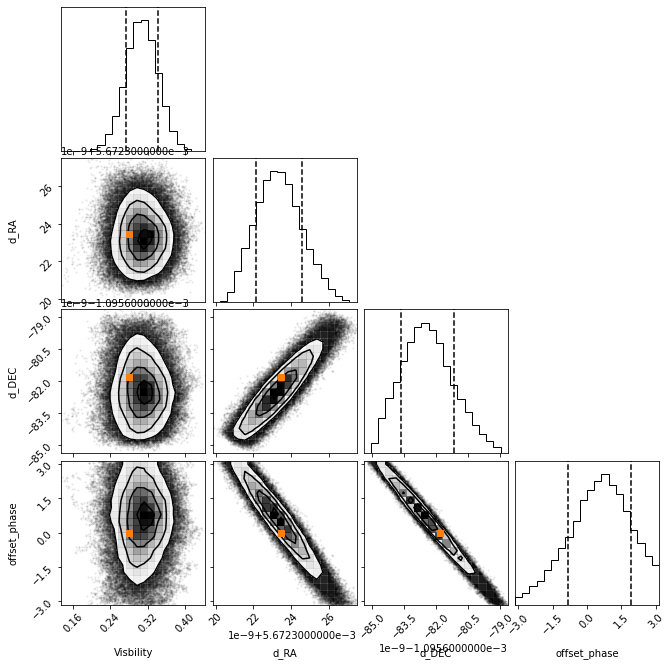

In [14]:
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_10x_ph_1.txt")
theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,0.0])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
#mcmc_data = np.delete(res, [0,1], axis=1)

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_RA','d_DEC','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, theo_par[None], marker="s", color="C1",label="Theo")

sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print(sigma)

In [17]:
QT.ph

-2.1765595179585695

590004
[5.21292468e-02 9.43142080e-10 7.84040094e-10 8.19029578e-01]


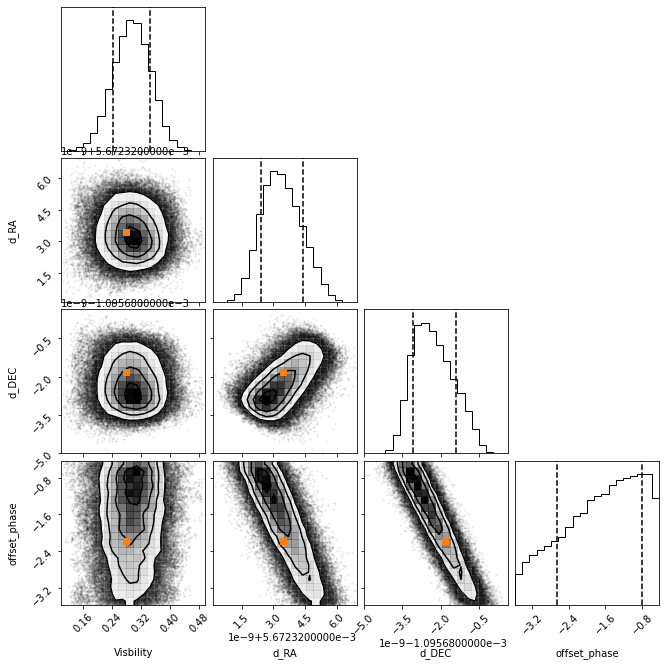

In [8]:
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_5x_ph_1.txt")
theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,QT.ph])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
#mcmc_data = np.delete(res, [0,1], axis=1)

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_RA','d_DEC','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, theo_par[None], marker="s", color="C1",label="Theo")

sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print(sigma)

590004
[6.66605999e-02 9.66467365e-10 8.29267604e-10 8.31484449e-01]


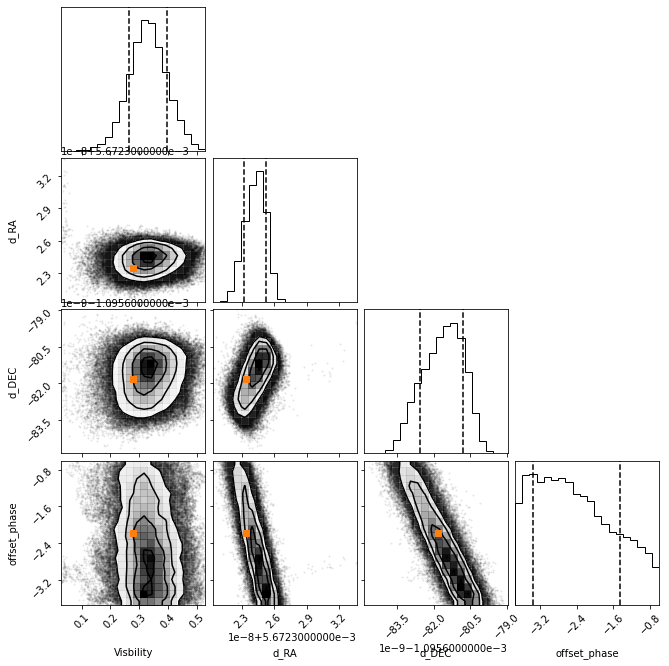

In [10]:
res = np.loadtxt("/home/zhi/SULI21/MCMC_output/sim_data_3x_ph_1.txt")
theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,QT.ph])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
#mcmc_data = np.delete(res, [0,1], axis=1)

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_RA','d_DEC','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, theo_par[None], marker="s", color="C1",label="Theo")

sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print(sigma)

590004
[3.66418177e-02 5.88618421e-10 5.34603203e-10 1.26443085e+00]


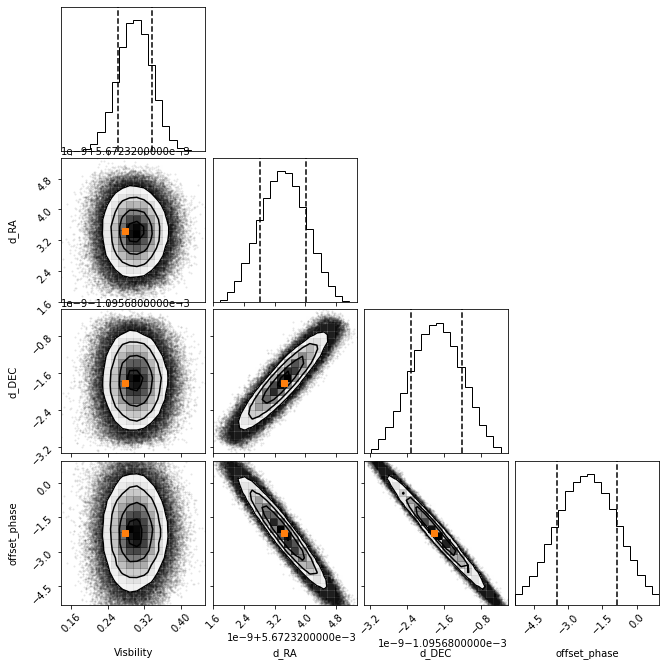

In [23]:
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/sim_data_400m_10x.txt")
theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,QT.ph])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
#mcmc_data = np.delete(res, [0,1], axis=1)

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','d_RA','d_DEC','offset_phase'],quantiles=(0.16, 0.84))
corner.overplot_points(figure, theo_par[None], marker="s", color="C1",label="Theo")

sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print(sigma)

In [26]:
# Comparing between Fisher and MCMC WITH an OFFSET PHASE
res = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/sim_data_400m_10x.txt")
maxRes = np.loadtxt("/home/Zhi/QA-sim/MCMC_output/sim_data_400m_10x.maxlike")

theo_par = np.array([0.2790452774098804, 0.005672323444045146, -0.0010956818183263065,0.0])

mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 
mcmc_data.shape
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma of parameters:", sigma)

#ra = ufloat(maxRes[3], sigma[1])
#dec = ufloat(maxRes[4],sigma[2])
#exp_d = sqrt(ra**2 + dec**2)
#print("Max loglike separation between sources:", exp_d)

k = (1-np.sqrt(1-task4.V**2))/task4.V**2
B = np.linalg.norm(baseline)
theo_d = np.linalg.norm(d_source[0,0,:])
theo_sigma = np.sqrt(6/(k*np.pi**2))/task4.V/np.sqrt(T*task4.avg_rate*10)*theo_par[2]/task4.N
print("Error of separation between sources by Fisher:", theo_sigma)

Sigma of parameters: [3.66418177e-02 5.88618421e-10 5.34603203e-10 1.26443085e+00]
Error of separation between sources by Fisher: -1.3961111174290299e-11
